#### Importing Functions

In [1]:
from utils import *

#### Importing the libraries

In [2]:
import cv2
import os
import tifffile # for reading tiff files. There are other modules that can do this, but tifffile is most stable on Windows
import numpy as np # for array handling
import matplotlib.pyplot as plt # for QC
import glob # to gather up image filepath lists
import rasterio
from rasterio.plot import show
from skimage import io
import scipy # same
import imagecodecs
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, f1_score, precision_score, recall_score
from skimage.transform import resize
from skimage.util import random_noise
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Input, BatchNormalization, Activation, Dense, Dropout
from tensorflow.keras.layers import Lambda, RepeatVector, Reshape
from tensorflow.keras.layers import concatenate, add
from tensorflow.keras.layers import Conv2D, Conv2DTranspose,MaxPooling2D, UpSampling2D
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau, Callback
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
from tensorflow.keras import backend as K

#### Define Directory

In [4]:
# Set a new working directory
new_directory = r"C:\Users\Chris\Desktop\Lectures\Semester_2\Advanced_programming\Data"
os.chdir(new_directory)

# Check if the working directory has been changed
current_directory = os.getcwd()
print("New Current Working Directory:", current_directory)

New Current Working Directory: C:\Users\Chris\Desktop\Lectures\Semester_2\Advanced_programming\Data


#### Create and Save Binary Mask

In [5]:
# Call output directory
mask_scenes = r".\mask_scenes"
mask_val = r".\mask_val"
create_dir(mask_scenes)
create_dir(mask_val)


# Create masks for scenes
input_path_scenes = r".\scenes"
output_path_scenes = r".\mask_scenes"

create_binary_mask(input_path_scenes, output_path_scenes)

# Create masks for val
input_path_val = r".\val"
output_path_val = r".\mask_val"

create_binary_mask(input_path_val, output_path_val)

#### Load and  Display the data 

In [6]:
training_file_path = r'.\scenes\*.tif'
testing_file_path = r'.\val\*.tif'

In [7]:
top_train_list = read_data(training_file_path)
print(top_train_list)

['.\\scenes\\L1C_T21DVJ_A026576_20220408T131906.tif'
 '.\\scenes\\L1C_T21EWK_A026776_20220422T125859.tif'
 '.\\scenes\\L1C_T23VMH_A024904_20211212T143513.tif'
 '.\\scenes\\L1C_T23VMH_A025147_20211229T142513.tif'
 '.\\scenes\\L1C_T23VNG_A025147_20211229T142513.tif'
 '.\\scenes\\L1C_T23VNH_A025147_20211229T142513.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-1.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-2.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-3.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-4.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-5.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-6.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-7.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-8.tif'
 '.\\scenes\\S2B_MSIL1C_20220128T1

In [8]:
#Available validation scenes
top_test_list = read_data(testing_file_path)
print(top_test_list)

['.\\val\\L1C_T21EXK_A026776_20220422T125859.tif'
 '.\\val\\S2B_MSIL1C_20220128T131859_N0400_R095_T20DNP_20220128T150039-11.tif'
 '.\\val\\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-1.tif'
 '.\\val\\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-11.tif'
 '.\\val\\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-3.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-2.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-3.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-4.tif'
 '.\\val\\S2B_MSIL2A_20211129T131909_N0301_R095_T19DEE_20211129T151203-5.tif'
 '.\\val\\T05CNQ_20200216T174429_B01.tif'
 '.\\val\\T13CEU_20230202T150219_B01.tif']


#### Visualize a Training Image for Testing

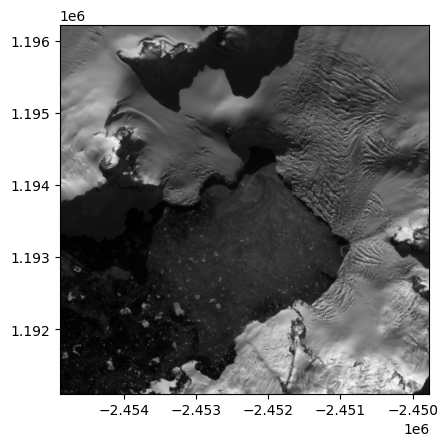

In [9]:
src = rasterio.open(".\scenes\S2B_MSIL1C_20220302T132919_N0400_R138_T20DMN_20220302T163212-8.tif")
img0 = show(src.read(1),transform=src.transform, cmap='gray')

#### Resize the Data

In [10]:
#creating empty arrays to store our data
imgResize = 512
channels = 3
train_dir, test_dir = create_arrays(512, 3)

In [11]:
resized_training_images = resize_images(imgResize, channels, top_train_list, train_dir)
resized_testing_images = resize_images(imgResize, channels, top_test_list, test_dir)

In [12]:
np.save('./train_images/data_train.npy', resized_training_images)
np.save('./test_images/data_test.npy', resized_training_images)

#### Let's process our Labels

##### Load our mask data

In [13]:
train_mask_path = r'.\mask_scenes\*.tif'

label_train_list = read_data(train_mask_path)
# print(label_train_list)

In [14]:
# BUG FIX
testing_mask_path = r'.\mask_val\*.tif'

label_test_list = read_data(testing_mask_path)
# print(label_test_list)

#### Visualize one of the training labels

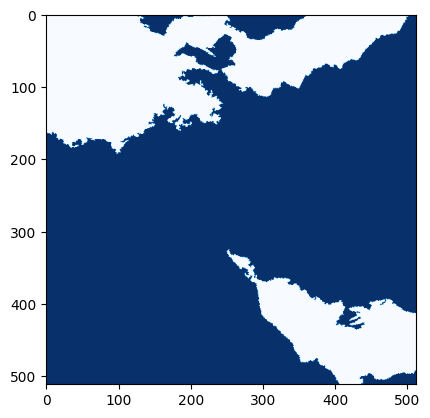

In [15]:
#Lets have a look at our labels
plot_label(label_train_list, 9)



#### Let's start reshaping our labels.

In [16]:
# Define the directory where you want to save the individual label images
label_save_dir_train = './train_label_images/'
label_save_dir_test = './test_label_images/'

# Using the function create_dir to create file directories for saving labelled images for training and testing
create_dir(label_save_dir_train)
create_dir(label_save_dir_test)

In [17]:
# Convert training labels to an array
label_train_total = label_list_to_array(label_train_list, imgResize, 1) 

In [18]:
# Convert testing labels to an array
label_test_total = label_list_to_array(label_test_list, imgResize, 1)

In [19]:
#onehot train label
onehot_label_train_total = onehot_label(label_train_total, label_train_list, imgResize, 2)

In [20]:
#onehot test label
onehot_label_test_total = onehot_label(label_test_total, label_test_list, imgResize, 2)

#### Checking how one-hot-encoded labels look like

[0. 1.]


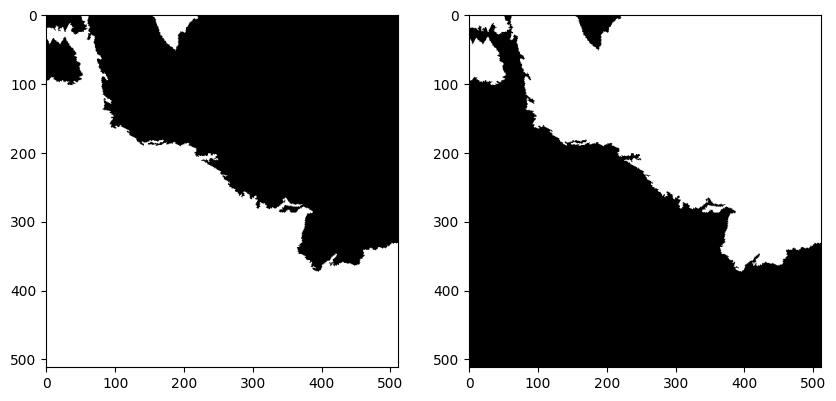

In [21]:
fig, axes = plt.subplots(1, 2, figsize=(10,10))
axes[0].imshow(onehot_label_test_total[2,:,:,0], cmap='gray')
axes[1].imshow(onehot_label_test_total[2,:,:,1], cmap='gray')
print(np.unique(onehot_label_train_total))

#### Save our Labels

In [22]:
np.save('./train_label_images/label_train.npy', onehot_label_train_total)
np.save('./test_label_images/label_test.npy', onehot_label_test_total)

## Training the Neural Network

This Tutorial was created by C. Baumhoer and is based on work from https://github.com/mmorphew/unet_remote_sensing & https://github.com/karolzak/keras-unet


#### Load our Data

In [23]:
data_train = './train_images/*.tif'
data_test = './test_images/*.tif'

In [28]:
# Load and convert train and testing data into arrays
data_files_train = read_data_array(data_train, imgResize, channels)
data_files_test = read_data_array(data_test, imgResize, channels)

# Load our labels
labels_train = np.load('./train_label_images/label_train.npy')
labels_test  = np.load('./test_label_images/label_test.npy')

C:\Users\Chris\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\rasterio\__init__.py:319: NotGeoreferencedWarning: Dataset has no geotransform, gcps, or rpcs. The identity matrix will be returned.
  dataset = DatasetReader(path, driver=driver, sharing=sharing, **kwargs)


In [29]:
print(data_files_train.shape)

AttributeError: 'NoneType' object has no attribute 'shape'

We need to tell Tensorflow the size of our input image. We select 512 by 512 since that was how we resized our image collection

In [25]:
nx = 512
ny = 512

To improve learning, let's standardize globally by subtracting the mean and dividing by the standard deviation.

In [9]:
# data_train_scaled = standardize_data(data_files_train)
# data_test_scaled = standardize_data(data_files_test)

In [27]:
# Standardization across all samples (band specific)
data_train_scaled = np.zeros(np.shape(data_files_train))
data_test_normalized = np.zeros((np.shape(data_files_train)))
for i in range(np.shape(data_files_train)[-1]):
    data_train_mean = np.mean(data_files_train[:,:,:,i])
    data_train_std = np.std(data_files_train[:,:,:,i])
    data_train_scaled[:,:,:,i] = (data_files_train[:,:,:,i]-data_train_mean)/data_train_std

data_train_scaled.ndim

IndexError: tuple index out of range

In [42]:
# Standardization across all samples (band specific)
data_test_scaled = np.zeros(np.shape(data_files_test))
data_test_normalized = np.zeros((np.shape(data_files_test)))
for i in range(np.shape(data_files_test)[-1]):
    data_test_mean = np.mean(data_files_test[:,:,:,i])
    data_test_std = np.std(data_files_test[:,:,:,i])
    data_test_scaled[:,:,:,i] = (data_files_test[:,:,:,i]-data_test_mean)/data_test_std

data_test_scaled.ndim

4

We assign our Data to Variables

In [28]:
x_train_data = data_train_scaled #data_train_scaled
y_labels_train = labels_train[:,:,:] # exclude clutter
x_test = data_test_scaled #data_test_scaled
y_labels_test = labels_test[:,:,:]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


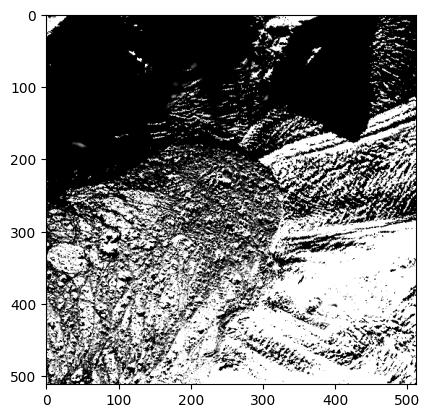

In [29]:
# Plot a random image to see if everything looks alright
plt.imshow(x_train_data[8])

We split our dataset into a portion for training and a portion for validation.

In [30]:
x_train, x_val, y_train, y_val = train_test_split(x_train_data, y_labels_train, test_size=0.2, shuffle=True, random_state=1234)

In [61]:
print(x_train_data.shape)

(33, 512, 512, 3)


Let's augment our training data, we flip the images in various ways, add noise, etc.

In [66]:
import numpy as np

# Initialize empty lists to store augmented data for x_train and y_train
augmented_x_train = []
augmented_y_train = []

# Vertical Image Augmentation for x_train
for x_sample in x_train_data:
    augmented_x_sample = np.flip(x_sample, axis=0)
    augmented_x_train.append(augmented_x_sample)

# Horizontal Image Augmentation for x_train
for x_sample in x_train_data:
    augmented_x_sample = np.flip(x_sample, axis=1)
    augmented_x_train.append(augmented_x_sample)

# Horizontal Vertical Image Augmentation for x_train
for x_sample in x_train_data:
    augmented_x_sample = np.flip(x_sample, axis=0)
    augmented_x_sample = np.flip(augmented_x_sample, axis=1)
    augmented_x_train.append(augmented_x_sample)

# Convert the list of augmented x_train samples to a NumPy array
augmented_x_train = np.array(augmented_x_train)

# Ensure that the number of samples in x_train and y_train matches
num_samples = min(augmented_x_train.shape[0], y_train.shape[0])
augmented_x_train = augmented_x_train[:num_samples]
y_train = y_train[:num_samples]

# Shuffle the data and select the first 99 samples
indices = np.random.permutation(num_samples)
x_train = augmented_x_train[indices[:99]]
y_train = y_train[indices[:99]]


In [67]:
print(x_train.shape)
print(y_train.shape)

(99, 512, 512, 3)
(99, 512, 512, 2)


#### Define the Neural Network

Let's create a model object, compile it, and summarize it so we can make sure the layers were built the way we wanted them to be built by Keras. We'll also define our optimizer, Adam, and pick a loss function and tracking metrics.

In [68]:
model = satellite_unet(input_shape=(512, 512, 3), num_classes=2, output_activation='sigmoid', num_layers=3 )
model.compile(optimizer=Adam(), loss='categorical_crossentropy', metrics=["categorical_accuracy", f1])
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_2 (InputLayer)        [(None, 512, 512, 3)]        0         []                            
                                                                                                  
 conv2d_23 (Conv2D)          (None, 512, 512, 64)         1792      ['input_2[0][0]']             
                                                                                                  
 batch_normalization_25 (Ba  (None, 512, 512, 64)         256       ['conv2d_23[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 conv2d_24 (Conv2D)          (None, 512, 512, 64)         36928     ['batch_normalization_25

----- 

Callbacks for instructing Tensorflow on how to behave during training. 

In [69]:
#Let's save our model checkpoints relative to epoch and loss
checkpoint_filepath = 'weights.{epoch:02d}-{val_loss:.2f}.h5'

In [70]:
callbacks = [
    EarlyStopping(monitor='val_loss', patience=20, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=30, min_lr=0.00001, verbose=1),
    ModelCheckpoint(checkpoint_filepath, monitor='val_categorical_accuracy',
    mode='max',verbose=1, save_best_only=True, save_weights_only=True)
]

#### Now let's train our model!

In [71]:
results = model.fit(x_train, y_train, batch_size= 4, epochs=2, callbacks=callbacks,
                   validation_data=(x_val, y_val))

Epoch 1/2
25/25 [==============================] - ETA: 0s - loss: 0.7738 - categorical_accuracy: 0.6195 - f1: 0.6011 
Epoch 1: val_categorical_accuracy improved from -inf to 0.57877, saving model to weights.01-0.77.h5
25/25 [==============================] - 508s 20s/step - loss: 0.7738 - categorical_accuracy: 0.6195 - f1: 0.6011 - val_loss: 0.7656 - val_categorical_accuracy: 0.5788 - val_f1: 0.5305 - lr: 0.0010
Epoch 2/2
25/25 [==============================] - ETA: 0s - loss: 0.6790 - categorical_accuracy: 0.6418 - f1: 0.5744 
Epoch 2: val_categorical_accuracy improved from 0.57877 to 0.58591, saving model to weights.02-0.81.h5
25/25 [==============================] - 499s 20s/step - loss: 0.6790 - categorical_accuracy: 0.6418 - f1: 0.5744 - val_loss: 0.8050 - val_categorical_accuracy: 0.5859 - val_f1: 0.5873 - lr: 0.0010


#### Accuracy Check

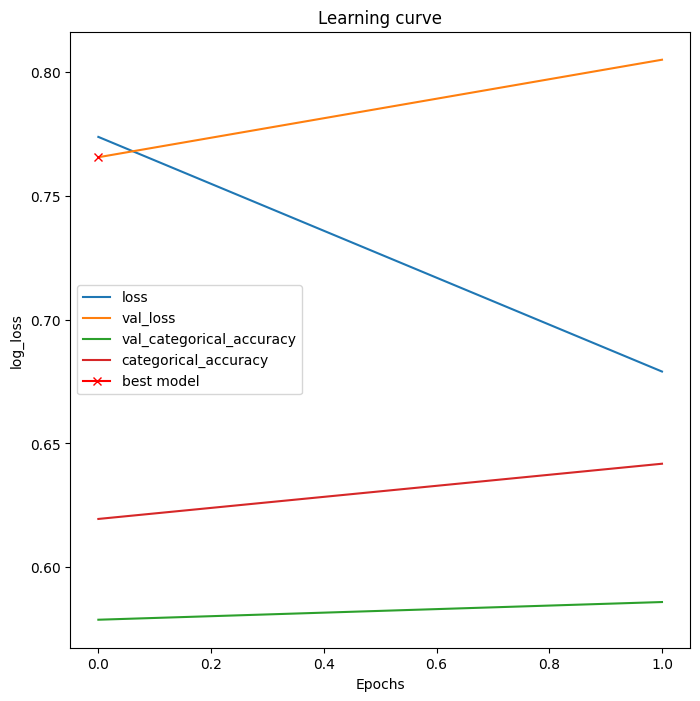

In [72]:
plt.figure(figsize=(8, 8))
plt.title("Learning curve")
plt.plot(results.history["loss"], label="loss")
plt.plot(results.history["val_loss"], label="val_loss")
plt.plot(results.history["val_categorical_accuracy"], label="val_categorical_accuracy")
plt.plot(results.history["categorical_accuracy"], label="categorical_accuracy")
plt.plot( np.argmin(results.history["val_loss"]), np.min(results.history["val_loss"]), marker="x", color="r", label="best model")
plt.xlabel("Epochs")
plt.ylabel("log_loss")
plt.legend();

#### Evaluate the trained weights and predict

In [74]:
# Load best model
# Have a look at all saved models and take the one with the highest epoch value
model.load_weights('./weights.02-0.81.h5')

In [76]:
# Evaluate on test set
eval = model.evaluate(x_test, y_labels_test)
print('Test loss:', eval[0])
print('Test accuracy:', eval[1])

1/1 [==============================] - 4s 4s/step - loss: 0.7492 - categorical_accuracy: 0.5630 - f1: 0.5756
Test loss: 0.7491633296012878
Test accuracy: 0.5630105137825012


In [77]:
# Predict on train, val and test
preds_train = model.predict(x_train[0:10], verbose=1)
preds_val = model.predict(x_val, verbose=1)
preds_test = model.predict(x_test, verbose=1)

1/1 [==============================] - 7s 7s/step


In [78]:
# Threshold prediction probabilities
preds_train_t = (preds_train > 0.5).astype(np.uint8)
preds_val_t = (preds_val > 0.5).astype(np.uint8)
preds_test_t = (preds_test > 0.5).astype(np.uint8)

#### Plot Results

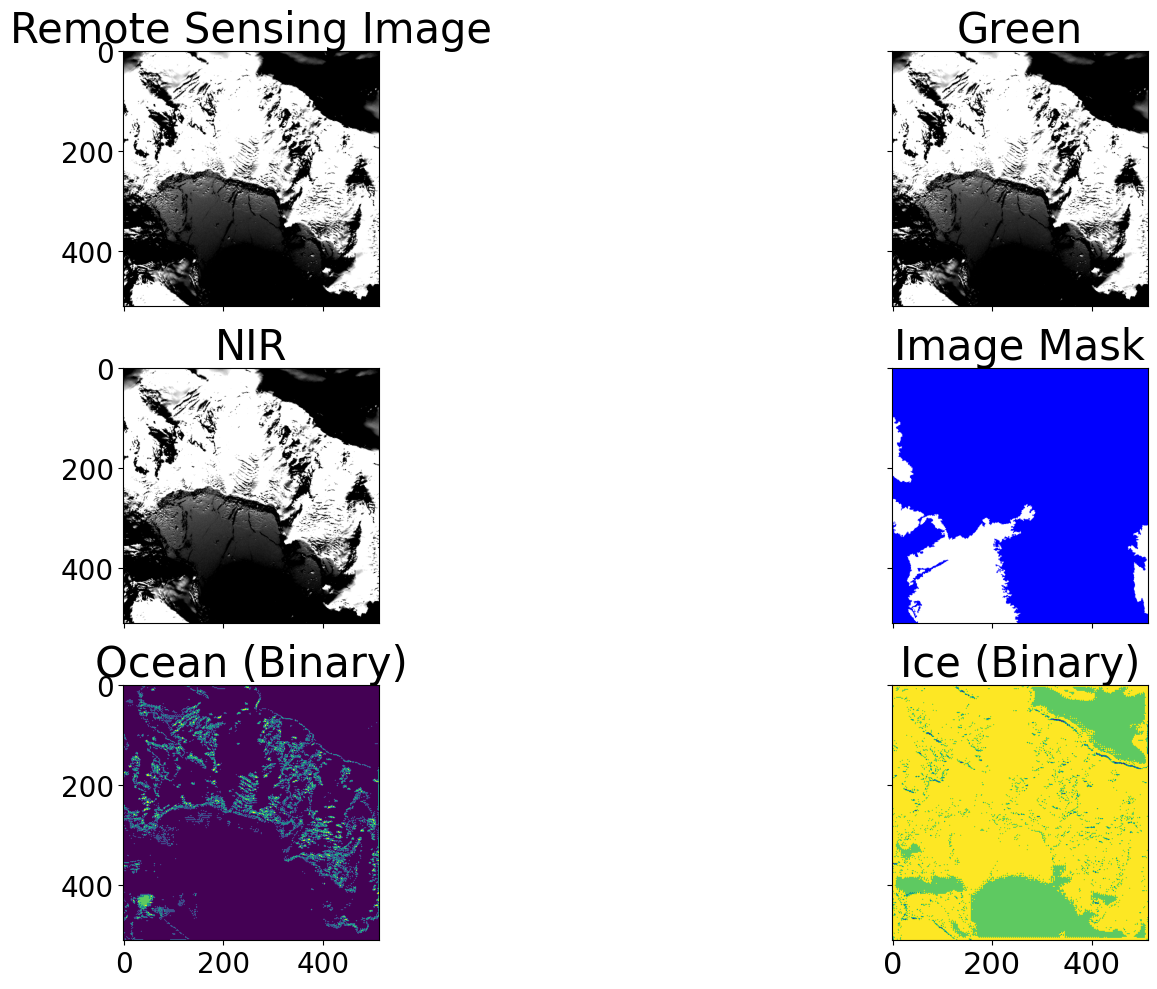

In [79]:
# Let's see how a prediction on the training data looks like
plot_sample_all(x_train, y_train, preds_train, preds_train_t, ix=9, filename='test.png')

Plot our test data as well

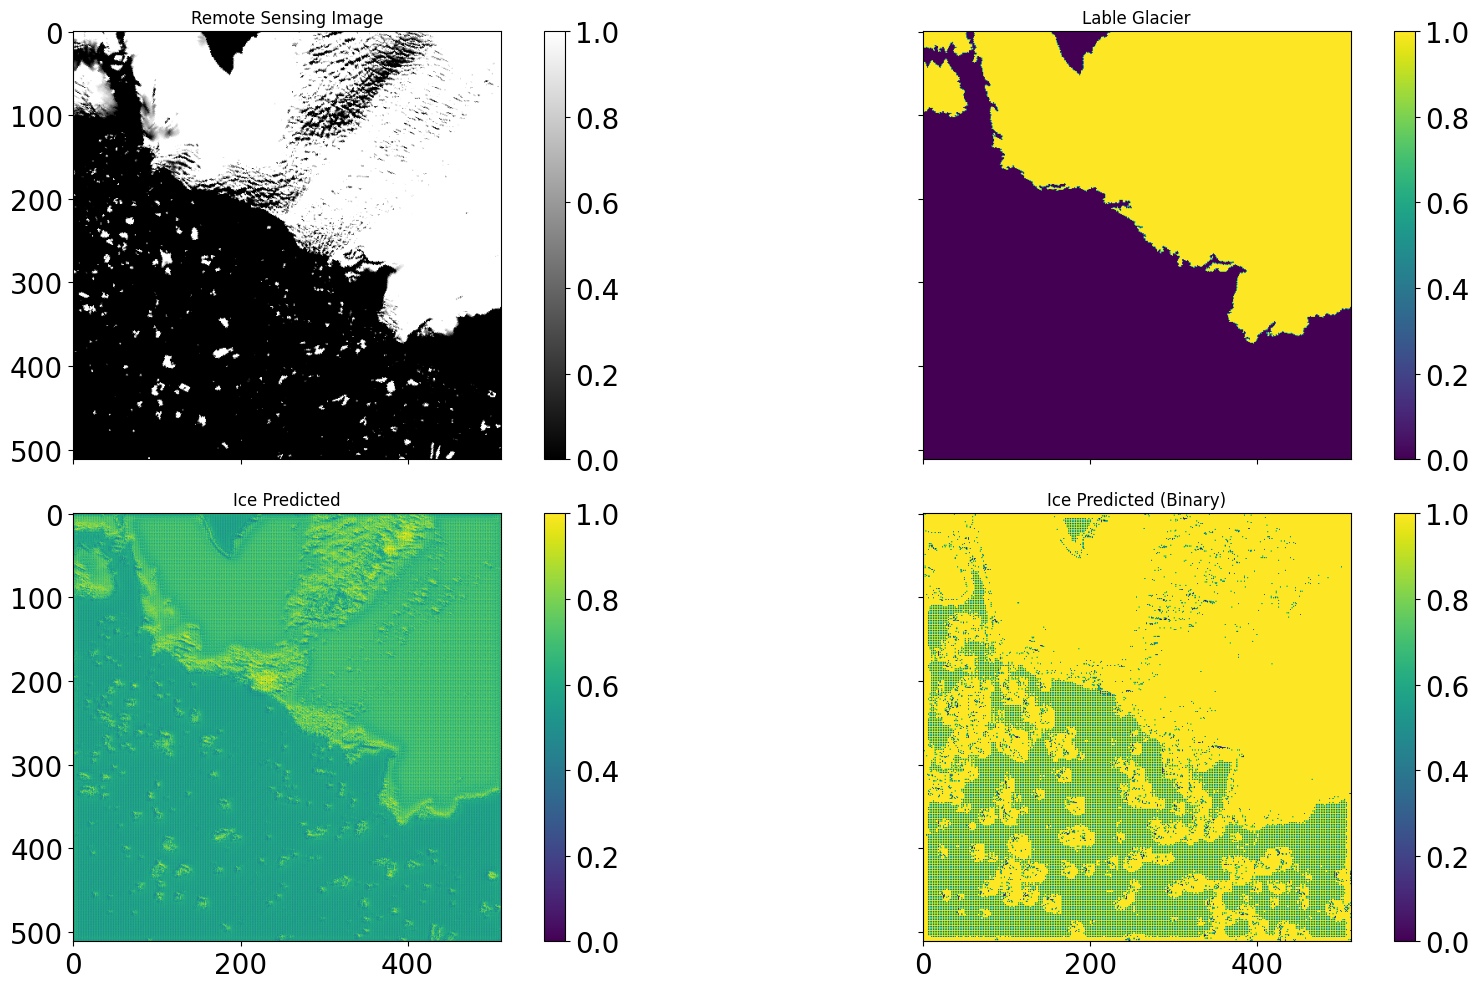

In [80]:
# Check if test data looks all right
plot_sample(x_test, y_labels_test, preds_test, preds_test_t, ix=1)

#### Accuracy Metrics

In [82]:
x_total = np.concatenate((x_train, x_val, x_test), axis=0)
y_total = np.concatenate((y_train, y_val, y_labels_test), axis=0)
pred_total = np.concatenate((preds_train_t, preds_val_t, preds_test_t), axis=0)

In [83]:
print_roc_metrics(y_val, preds_val_t)

Confusion matrix:
[[1051653  783355]
 [ 784122 1050886]]
F1 score: 0.5728
Recall score: 0.5727
Precision score: 0.5729
